

# 以下为网络和参数定义，训练/测试都需要先运行这一段



In [ ]:
# import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore import nn, Tensor, Model,context
from mindspore import dtype as mstype
from mindspore.nn.metrics import Accuracy
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.callback import SummaryCollector
from mindspore.train.callback import Callback
import matplotlib.pyplot as plt
from mindspore import load_checkpoint, load_param_into_net
import math
import numpy as np
import mindspore.dataset.vision.c_transforms as c_trans

#定义神经网络
class Net(nn.Cell):
    def __init__(self, num_class=10, num_channel=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, num_class)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
net = Net()
epochs = 50                 #训练轮次
batch_size = 128           #批大小
learning_rate = 1e-3       #学习率
train_num=50000            #训练集数量
time_stamp="_6_18_17_20_"   #开始训练时的时间：_月_日_时_分_
model_time="_6_18_17_20_"   #所要加载模型对应的时间



# 以下为数据处理



In [2]:
#构建数据集
sampler = ds.SequentialSampler(num_samples=train_num)
dataset_origin = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\train", sampler=sampler)
#数据类型转换
type_cast_op_image = C.TypeCast(mstype.float32)
type_cast_op_label = C.TypeCast(mstype.int32)
HWC2CHW = CV.HWC2CHW()
#dataset_origin = dataset_origin.map(operations=[type_cast_op_image, HWC2CHW], input_columns="image")
#dataset_origin = dataset_origin.map(operations=type_cast_op_label, input_columns="label")




In [3]:
#数据增强
random_horizontal_flip = c_trans.RandomHorizontalFlip(prob=1)
dataset_flip = dataset_origin.map(operations=random_horizontal_flip, input_columns=["image"])
dataset_origin = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\train", sampler=sampler)
dataset=dataset_origin.concat(dataset_flip)
dataset = dataset.map(operations=[type_cast_op_image, HWC2CHW], input_columns="image")
dataset = dataset.map(operations=type_cast_op_label, input_columns="label")
dataset = dataset.batch(batch_size)





# 以下为训练代码，若是想直接测试现成模型可跳过这一段



In [4]:
#读取验证集
val_num=10000
sampler_eval = ds.SequentialSampler(num_samples=val_num)
dataset_eval = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\test", sampler=sampler_eval)
#数据类型转换
dataset_eval = dataset_eval.map(operations=[type_cast_op_image, HWC2CHW], input_columns="image")
dataset_eval = dataset_eval.map(operations=type_cast_op_label, input_columns="label")
dataset_eval = dataset_eval.batch(batch_size)

eval_per_step=1
class EvalCallBack(Callback):
    def __init__(self, model,dataset, dataset_eval, eval_per_step, step_acc,step_loss):
        self.model = model
        self.dataset_eval = dataset_eval
        self.dataset_train = dataset
        self.eval_per_step = eval_per_step
        self.step_acc = step_acc
        self.step_loss=step_loss

    def step_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        #print("epoch:",cur_epoch)
        if cur_epoch==1:
            cur_step=cb_param.cur_step_num
            if cur_step%1 == 0:
                acc = self.model.eval(self.dataset_eval, dataset_sink_mode=False)
                self.step_acc["step"].append(cur_step)
                self.step_acc["acc"].append(acc["accuracy"])
            if cur_step%1 == 0:
                loss = self.model.eval(self.dataset_train, dataset_sink_mode=False)
                self.step_loss["step"].append(cur_step)
                self.step_loss["loss"].append(loss["loss"])

# set parameters of check point
config_ck = CheckpointConfig(save_checkpoint_steps=10, keep_checkpoint_max=1) 
# apply parameters of check point
ckpoint_cb = ModelCheckpoint(prefix="model"+time_stamp,directory="models", config=config_ck) 
#summary_cb = SummaryCollector(summary_dir='./summary_dir')
summary_collector = SummaryCollector(summary_dir='./summary_dir', collect_freq=1)
# 定义超参、损失函数及优化器
optim = nn.Adam(params=net.trainable_params(), learning_rate=learning_rate)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

metrics = {
    'accuracy': nn.Accuracy(),
    'loss': nn.Loss(),
}
context.set_context(mode=context.GRAPH_MODE)
# 输入训练轮次和数据集进行训练
model = Model(net, loss_fn=loss, optimizer=optim, metrics=metrics)
step_acc = {"step": [], "acc": []}
step_loss = {"step": [], "loss": []}
eval_cb = EvalCallBack(model,dataset, dataset_eval, eval_per_step, step_acc,step_loss)
model.train(epoch=epochs, train_dataset=dataset,dataset_sink_mode=False,callbacks=[ckpoint_cb, LossMonitor(),eval_cb])

epoch: 1 step: 1, loss is 2.3029962
epoch: 1 step: 2, loss is 2.3026655
epoch: 1 step: 3, loss is 2.3024056
epoch: 1 step: 4, loss is 2.3028538
epoch: 1 step: 5, loss is 2.302058
epoch: 1 step: 6, loss is 2.3018992
epoch: 1 step: 7, loss is 2.3051035
epoch: 1 step: 8, loss is 2.3036182
epoch: 1 step: 9, loss is 2.3012488
epoch: 1 step: 10, loss is 2.3004496
epoch: 1 step: 11, loss is 2.300486
epoch: 1 step: 12, loss is 2.2997053
epoch: 1 step: 13, loss is 2.3016381
epoch: 1 step: 14, loss is 2.2921712
epoch: 1 step: 15, loss is 2.3218505
epoch: 1 step: 16, loss is 2.294335
epoch: 1 step: 17, loss is 2.299705
epoch: 1 step: 18, loss is 2.299868
epoch: 1 step: 19, loss is 2.2907233
epoch: 1 step: 20, loss is 2.289138
epoch: 1 step: 21, loss is 2.2785993
epoch: 1 step: 22, loss is 2.2881963
epoch: 1 step: 23, loss is 2.2874913
epoch: 1 step: 24, loss is 2.2909856
epoch: 1 step: 25, loss is 2.272611
epoch: 1 step: 26, loss is 2.2650068
epoch: 1 step: 27, loss is 2.241147
epoch: 1 step: 28,

epoch: 1 step: 221, loss is 1.7455689
epoch: 1 step: 222, loss is 1.6691898
epoch: 1 step: 223, loss is 1.673531
epoch: 1 step: 224, loss is 1.6782466
epoch: 1 step: 225, loss is 1.673172
epoch: 1 step: 226, loss is 1.4751201
epoch: 1 step: 227, loss is 1.6194403
epoch: 1 step: 228, loss is 1.6840335
epoch: 1 step: 229, loss is 1.6680939
epoch: 1 step: 230, loss is 1.5687386
epoch: 1 step: 231, loss is 1.7032045
epoch: 1 step: 232, loss is 1.7015493
epoch: 1 step: 233, loss is 1.6539992
epoch: 1 step: 234, loss is 1.6307336
epoch: 1 step: 235, loss is 1.5772446
epoch: 1 step: 236, loss is 1.6968775
epoch: 1 step: 237, loss is 1.7683566
epoch: 1 step: 238, loss is 1.7001698
epoch: 1 step: 239, loss is 1.6352237
epoch: 1 step: 240, loss is 1.7625613
epoch: 1 step: 241, loss is 1.8186272
epoch: 1 step: 242, loss is 1.6502286
epoch: 1 step: 243, loss is 1.6704495
epoch: 1 step: 244, loss is 1.7370849
epoch: 1 step: 245, loss is 1.6496768
epoch: 1 step: 246, loss is 1.7453656
epoch: 1 step:

epoch: 1 step: 438, loss is 1.5835541
epoch: 1 step: 439, loss is 1.5845159
epoch: 1 step: 440, loss is 1.6720506
epoch: 1 step: 441, loss is 1.5790354
epoch: 1 step: 442, loss is 1.7023907
epoch: 1 step: 443, loss is 1.6831834
epoch: 1 step: 444, loss is 1.5527631
epoch: 1 step: 445, loss is 1.7862643
epoch: 1 step: 446, loss is 1.5293195
epoch: 1 step: 447, loss is 1.5409913
epoch: 1 step: 448, loss is 1.4462727
epoch: 1 step: 449, loss is 1.7114501
epoch: 1 step: 450, loss is 1.6417439
epoch: 1 step: 451, loss is 1.7380353
epoch: 1 step: 452, loss is 1.6438417
epoch: 1 step: 453, loss is 1.5528259
epoch: 1 step: 454, loss is 1.6423041
epoch: 1 step: 455, loss is 1.3997457
epoch: 1 step: 456, loss is 1.568557
epoch: 1 step: 457, loss is 1.6340438
epoch: 1 step: 458, loss is 1.4457355
epoch: 1 step: 459, loss is 1.6146291
epoch: 1 step: 460, loss is 1.612155
epoch: 1 step: 461, loss is 1.7828302
epoch: 1 step: 462, loss is 1.6206812
epoch: 1 step: 463, loss is 1.5581743
epoch: 1 step:

epoch: 1 step: 655, loss is 1.5159727
epoch: 1 step: 656, loss is 1.6501752
epoch: 1 step: 657, loss is 1.5899069
epoch: 1 step: 658, loss is 1.3480874
epoch: 1 step: 659, loss is 1.4342513
epoch: 1 step: 660, loss is 1.598942
epoch: 1 step: 661, loss is 1.6017607
epoch: 1 step: 662, loss is 1.520187
epoch: 1 step: 663, loss is 1.529497
epoch: 1 step: 664, loss is 1.559743
epoch: 1 step: 665, loss is 1.5164171
epoch: 1 step: 666, loss is 1.551502
epoch: 1 step: 667, loss is 1.5471427
epoch: 1 step: 668, loss is 1.5317233
epoch: 1 step: 669, loss is 1.4733169
epoch: 1 step: 670, loss is 1.5453744
epoch: 1 step: 671, loss is 1.5559984
epoch: 1 step: 672, loss is 1.5742104
epoch: 1 step: 673, loss is 1.485093
epoch: 1 step: 674, loss is 1.505654
epoch: 1 step: 675, loss is 1.4894114
epoch: 1 step: 676, loss is 1.5311942
epoch: 1 step: 677, loss is 1.3581522
epoch: 1 step: 678, loss is 1.4849709
epoch: 1 step: 679, loss is 1.437302
epoch: 1 step: 680, loss is 1.6466651
epoch: 1 step: 681, 

In [5]:
result=model.eval(dataset_eval,dataset_sink_mode=False)
print(result)

{'accuracy': 0.4602, 'loss': 1.4789268034922927}


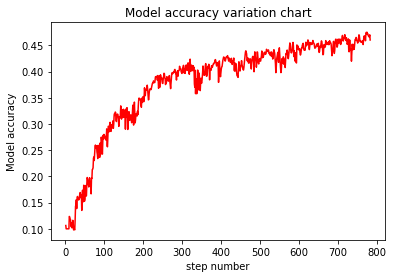

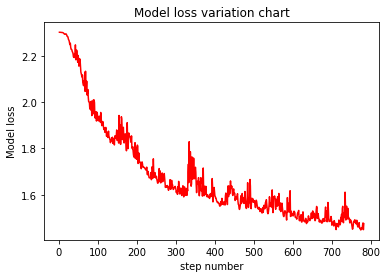

In [9]:


def eval_show_acc(step_acc):
    plt.xlabel("step number")
    plt.ylabel("Model accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(step_acc["step"], step_acc["acc"], "red")
    plt.savefig('accuracy4.png',dpi=600)
    plt.show()
def eval_show_loss(step_loss):
    plt.xlabel("step number")
    plt.ylabel("Model loss")
    plt.title("Model loss variation chart")
    plt.plot(step_loss["step"], step_loss["loss"], "red")
    plt.savefig('loss4.png',dpi=600)
    plt.show()
    
eval_show_acc(step_acc)
eval_show_loss(step_loss)



# 以下为测试代码，可以直接加载训练好的模型



The structure of network:

Labels:        [3 4 8 5 7 0 1 8 8 4 9 3 3 4 8 2 7 7]
Predictions:   [3 3 1 3 7 8 1 1 8 6 8 3 3 4 0 2 7 7]
Accuracy:      0.5555555555555556


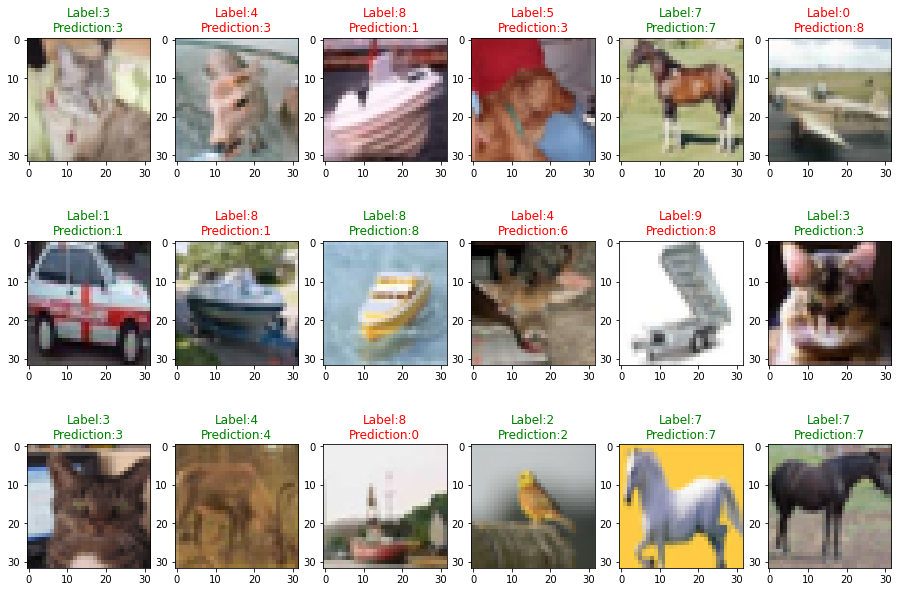

In [15]:

test_num=18
#weight=np.random.randint(0,1,18,int)
#sampler_pred = ds.SequentialSampler(num_samples=test_num)
#sampler_pred = ds.WeightedRandomSampler(weight,num_samples=18)
id = np.random.randint(0,30)
sampler_pred = ds.DistributedSampler(num_shards=50, shard_id=id, shuffle=False, num_samples=18)
dataset_pred = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\test", sampler=sampler_pred)
    #print(data['image'].shape)
#dataset_paint = dataset_pred
image_list1, label_list1 = [], []
for data in dataset_pred.create_dict_iterator():
    image_list1.append(data['image'])
    label_list1.append(data['label'])
    images=data['image']
type_cast_op_image = C.TypeCast(mstype.float32)
type_cast_op_label = C.TypeCast(mstype.int32)
HWC2CHW = CV.HWC2CHW()
dataset_pred = dataset_pred.map(operations=[type_cast_op_image, HWC2CHW], input_columns="image")
dataset_pred = dataset_pred.map(operations=type_cast_op_label, input_columns="label")
dataset_pred = dataset_pred.batch(test_num)
#dataset_paint = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\test", sampler=sampler_pred)

# 将模型参数存入parameter的字典中
model_path="models\\model"+model_time+"-"+str(epochs)+"_"+str(2*math.ceil(train_num/batch_size))+".ckpt"
#这里可以改模型
model_path="models\\model_6_17_22_50_-50_3125.ckpt"

net_trained=Net()
param_dict = load_checkpoint(model_path)
# 将参数加载到网络中
load_param_into_net(net_trained, param_dict)
print("The structure of network:\n")
#for m in net.parameters_and_names():
    #print(m)
#print("\n")
#print(dataset_pred)
for data in dataset_pred.create_dict_iterator():
    preds=np.argmax(net_trained(data['image']),axis=1)
    labels=data['label']
    print("Labels:       ",labels)
    print("Predictions:  ",preds)
print("Accuracy:     ",sum(preds==labels)/test_num)
judge = preds==labels
for i in range(test_num):
    plt.subplot(3,int(test_num/3),i+1)
    plt.subplots_adjust(left=3, bottom=3, right=5, top=5)
    plt.imshow(image_list1[i].asnumpy())
    if judge[i]==True:
        plt.title('Label:{0}\nPrediction:{1}'.format(labels[i],preds[i]),color='green')
    else:
        plt.title('Label:{0}\nPrediction:{1}'.format(labels[i],preds[i]),color='red')
plt.show()




# 以下为代码调试区



In [33]:
print(label_list1)
#plt.imshow(image[0])
#plt.show
#print(label_list1[5])
#print(preds[0]==label_list1['value'])


[Tensor(shape=[], dtype=UInt32, value= 7), Tensor(shape=[], dtype=UInt32, value= 2), Tensor(shape=[], dtype=UInt32, value= 8), Tensor(shape=[], dtype=UInt32, value= 9), Tensor(shape=[], dtype=UInt32, value= 7), Tensor(shape=[], dtype=UInt32, value= 2), Tensor(shape=[], dtype=UInt32, value= 3), Tensor(shape=[], dtype=UInt32, value= 4), Tensor(shape=[], dtype=UInt32, value= 4), Tensor(shape=[], dtype=UInt32, value= 3), Tensor(shape=[], dtype=UInt32, value= 5), Tensor(shape=[], dtype=UInt32, value= 6), Tensor(shape=[], dtype=UInt32, value= 7), Tensor(shape=[], dtype=UInt32, value= 6), Tensor(shape=[], dtype=UInt32, value= 4), Tensor(shape=[], dtype=UInt32, value= 6), Tensor(shape=[], dtype=UInt32, value= 6), Tensor(shape=[], dtype=UInt32, value= 3)]


In [125]:
print(labels)
print(preds)
print(preds==labels)

[0 5 2 9 3 3 7 6 8 5 9 3 4 7 5 3 7 6]
[0 3 0 9 3 4 7 6 0 5 8 3 0 2 3 2 0 6]
[ True False False  True  True False  True  True False  True False  True
 False False False False False  True]


Source image Shape : (32, 32, 3) , Source label : 0
Flipped image Shape: (32, 32, 3) , Flipped label: 0
------
Source image Shape : (32, 32, 3) , Source label : 5
Flipped image Shape: (32, 32, 3) , Flipped label: 5
------


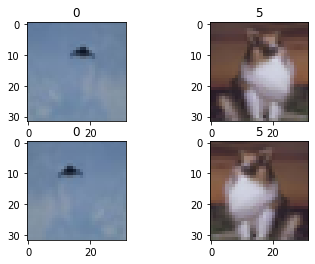

In [46]:

ds.config.set_seed(6)
ds.config.set_num_parallel_workers(1)

test_num=2
sampler_pred = ds.RandomSampler(num_samples=test_num)
dataset_pred = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\test", sampler=sampler_pred)
random_horizontal_flip = c_trans.RandomHorizontalFlip(prob=1)
dataset2 = dataset_pred.map(operations=random_horizontal_flip, input_columns=["image"])

image_list1, label_list1 = [], []
image_list2, label_list2 = [], []
for data1, data2 in zip(dataset_pred.create_dict_iterator(), dataset2.create_dict_iterator()):
    image_list1.append(data1['image'])
    label_list1.append(data1['label'])
    print("Source image Shape :", data1['image'].shape, ", Source label :", data1['label'])
    image_list2.append(data2['image'])
    label_list2.append(data2['label'])
    print("Flipped image Shape:", data2['image'].shape, ", Flipped label:", data2['label'])
    print("------")

num_samples = len(image_list1) + len(image_list2)
for i in range(num_samples):
    if i < len(image_list1):
        plt.subplot(2, len(image_list1), i + 1)
        plt.imshow(image_list1[i].asnumpy())
        plt.title(label_list1[i].asnumpy())
    else:
        plt.subplot(2, len(image_list2), i + 1)
        plt.imshow(image_list2[i % len(image_list2)].asnumpy())
        plt.title(label_list2[i % len(image_list2)].asnumpy())
plt.show()


In [27]:
for data in dataset2.create_dict_iterator():
    print(data)

for data in dataset_pred.create_dict_iterator():
    print(data)

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[ 98, 122, 149],
  [100, 124, 151],
  [100, 124, 152],
  ...
  [ 97, 122, 157],
  [ 94, 119, 154],
  [ 93, 119, 154]],
 [[101, 125, 153],
  [102, 126, 154],
  [103, 127, 155],
  ...
  [ 96, 122, 157],
  [ 96, 122, 157],
  [ 96, 122, 157]],
 [[100, 124, 152],
  [102, 126, 154],
  [103, 127, 155],
  ...
  [ 95, 121, 156],
  [ 97, 123, 157],
  [ 97, 123, 158]],
 ...
 [[128, 145, 162],
  [127, 144, 162],
  [127, 144, 161],
  ...
  [114, 138, 157],
  [117, 137, 158],
  [127, 145, 167]],
 [[130, 147, 164],
  [128, 146, 164],
  [127, 144, 163],
  ...
  [117, 140, 161],
  [122, 143, 163],
  [130, 148, 169]],
 [[128, 145, 161],
  [126, 143, 161],
  [126, 142, 160],
  ...
  [116, 139, 161],
  [123, 143, 162],
  [127, 146, 164]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 0)}
{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[ 82,  61,  56],
  [ 83,  62,  57],
  [ 84,  63,  58],
  ...
  [ 82,  62,  61],
  [ 81,  60,  59],
  [

In [49]:
test_num=1
sampler_pred = ds.RandomSampler(num_samples=test_num)
dataset_pred = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\test", sampler=sampler_pred)
random_horizontal_flip = c_trans.RandomHorizontalFlip(prob=1)
dataset2 = dataset_pred.map(operations=random_horizontal_flip, input_columns=["image"])
dataset_pred = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\test", sampler=sampler_pred)

type_cast_op_image = C.TypeCast(mstype.float32)
type_cast_op_label = C.TypeCast(mstype.int32)
HWC2CHW = CV.HWC2CHW()
dataset_pred = dataset_pred.map(operations=[type_cast_op_image, HWC2CHW], input_columns="image")
dataset_pred = dataset_pred.map(operations=type_cast_op_label, input_columns="label")
dataset2 = dataset2.map(operations=[type_cast_op_image, HWC2CHW], input_columns="image")
dataset2 = dataset2.map(operations=type_cast_op_label, input_columns="label")
for data in dataset2.create_dict_iterator():
    print(data)
dataset=dataset_pred.concat(dataset2)
print("____________________________________________________________________________________________________________")
for data in dataset.create_dict_iterator():
    print(data)


{'image': Tensor(shape=[3, 32, 32], dtype=Float32, value=
[[[9.80000000e+001, 1.00000000e+002, 1.00000000e+002 ... 9.70000000e+001, 9.40000000e+001, 9.30000000e+001],
  [1.01000000e+002, 1.02000000e+002, 1.03000000e+002 ... 9.60000000e+001, 9.60000000e+001, 9.60000000e+001],
  [1.00000000e+002, 1.02000000e+002, 1.03000000e+002 ... 9.50000000e+001, 9.70000000e+001, 9.70000000e+001],
  ...
  [1.28000000e+002, 1.27000000e+002, 1.27000000e+002 ... 1.14000000e+002, 1.17000000e+002, 1.27000000e+002],
  [1.30000000e+002, 1.28000000e+002, 1.27000000e+002 ... 1.17000000e+002, 1.22000000e+002, 1.30000000e+002],
  [1.28000000e+002, 1.26000000e+002, 1.26000000e+002 ... 1.16000000e+002, 1.23000000e+002, 1.27000000e+002]],
 [[1.22000000e+002, 1.24000000e+002, 1.24000000e+002 ... 1.22000000e+002, 1.19000000e+002, 1.19000000e+002],
  [1.25000000e+002, 1.26000000e+002, 1.27000000e+002 ... 1.22000000e+002, 1.22000000e+002, 1.22000000e+002],
  [1.24000000e+002, 1.26000000e+002, 1.27000000e+002 ... 1.2100

In [37]:
test_num=16
sampler_pred = ds.RandomSampler(num_samples=test_num)
dataset_pred = ds.Cifar10Dataset("cifar-10-binary\\cifar-10-batches-bin\\test", sampler=sampler_pred)
    #print(data['image'].shape)
type_cast_op_image = C.TypeCast(mstype.float32)
type_cast_op_label = C.TypeCast(mstype.int32)
HWC2CHW = CV.HWC2CHW()
dataset_pred = dataset_pred.map(operations=[type_cast_op_image, HWC2CHW], input_columns="image")
dataset_pred = dataset_pred.map(operations=type_cast_op_label, input_columns="label")
for data in dataset_pred.create_dict_iterator():
    print(data)

{'image': Tensor(shape=[3, 32, 32], dtype=Float32, value=
[[[9.30000000e+001, 9.40000000e+001, 9.70000000e+001 ... 1.00000000e+002, 1.00000000e+002, 9.80000000e+001],
  [9.60000000e+001, 9.60000000e+001, 9.60000000e+001 ... 1.03000000e+002, 1.02000000e+002, 1.01000000e+002],
  [9.70000000e+001, 9.70000000e+001, 9.50000000e+001 ... 1.03000000e+002, 1.02000000e+002, 1.00000000e+002],
  ...
  [1.27000000e+002, 1.17000000e+002, 1.14000000e+002 ... 1.27000000e+002, 1.27000000e+002, 1.28000000e+002],
  [1.30000000e+002, 1.22000000e+002, 1.17000000e+002 ... 1.27000000e+002, 1.28000000e+002, 1.30000000e+002],
  [1.27000000e+002, 1.23000000e+002, 1.16000000e+002 ... 1.26000000e+002, 1.26000000e+002, 1.28000000e+002]],
 [[1.19000000e+002, 1.19000000e+002, 1.22000000e+002 ... 1.24000000e+002, 1.24000000e+002, 1.22000000e+002],
  [1.22000000e+002, 1.22000000e+002, 1.22000000e+002 ... 1.27000000e+002, 1.26000000e+002, 1.25000000e+002],
  [1.23000000e+002, 1.23000000e+002, 1.21000000e+002 ... 1.2700

In [61]:
print(str(2*math.ceil(train_num/batch_size)))

10
